Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/09/naive_bayes_mnist_torch.ipynb

<a href="https://colab.research.google.com/github/arpitvaghela/probml-notebooks/blob/main/notebooks-d2l/naive_bayes_mnist_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Naive Bayes classifiers

We show how to implement Naive Bayes classifiers from scratch.
We use binary features, and 2 classes.
Based on sec 18.9 of http://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html.


In [1]:
import numpy as np

try:
    import torchvision
except ModuleNotFoundError:
    %pip install -qq torchvision
    import torchvision

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

!mkdir figures # for saving plots

key = jax.random.PRNGKey(1)

mkdir: cannot create directory ‘figures’: File exists


In [2]:
# helper function to show images
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    # modified from https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        img = np.array(img)
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

# Get data

We use a binarized version of MNIST.


In [3]:
mnist_train = torchvision.datasets.MNIST(
    root="./temp",
    train=True,
    transform=lambda x: jnp.array([jnp.array(x) / 255]),
    download=True,
)
mnist_test = torchvision.datasets.MNIST(
    root="./temp",
    train=False,
    transform=lambda x: jnp.array([jnp.array(x) / 255]),
    download=True,
)

In [4]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./temp
    Split: Train
    StandardTransform
Transform: <function <lambda> at 0x7f9b642bfa60>


In [5]:
image, label = mnist_train[2]
print(type(image))
print(image.shape)
print(type(label))
print(label)

<class 'jaxlib.xla_extension.DeviceArray'>
(1, 28, 28)
<class 'int'>
4


In [6]:
image[0, 15:20, 15:20]  # not binary (pytorch rescales to 0:1)

DeviceArray([[0.35686275, 0.10980392, 0.01960784, 0.9137255 , 0.98039216],
             [0.        , 0.        , 0.4       , 0.99607843, 0.8627451 ],
             [0.        , 0.        , 0.6627451 , 0.99607843, 0.5372549 ],
             [0.        , 0.        , 0.6627451 , 0.99607843, 0.22352941],
             [0.        , 0.        , 0.6627451 , 0.99607843, 0.22352941]],            dtype=float32)

In [7]:
[jnp.min(image), jnp.max(image)]

[DeviceArray(0., dtype=float32), DeviceArray(1., dtype=float32)]

In [8]:
print(mnist_train[0][0].shape)  # (1,28,28)
indices = [0, 1]
xx = jnp.stack([mnist_train[i][0] for i in indices])
print(xx.shape)
xx = jnp.stack([mnist_train[i][0] for i in indices], axis=1)
print(xx.shape)
xx = jnp.stack([mnist_train[i][0] for i in indices], axis=1).squeeze(0)
print(xx.shape)

(1, 28, 28)
(2, 1, 28, 28)
(1, 2, 28, 28)
(2, 28, 28)


In [9]:
# convert from torch.tensor to numpy, extract subset of indices, optionally binarize
def get_data(data, indices=None, binarize=True):
    N = len(data)
    if indices is None:
        indices = range(0, N)
    X = jnp.stack([data[i][0] for i in indices], axis=1).squeeze(0)  # (N,28,28)
    if binarize:
        X = X > 0.5
    y = jnp.array([data[i][1] for i in indices])
    return X, y

[(10, 28, 28), (10,)]
[[0.7294118  0.99215686 0.99215686 0.5882353  0.10588235]
 [0.0627451  0.3647059  0.9882353  0.99215686 0.73333335]
 [0.         0.         0.9764706  0.99215686 0.9764706 ]
 [0.50980395 0.7176471  0.99215686 0.99215686 0.8117647 ]
 [0.99215686 0.99215686 0.99215686 0.98039216 0.7137255 ]]


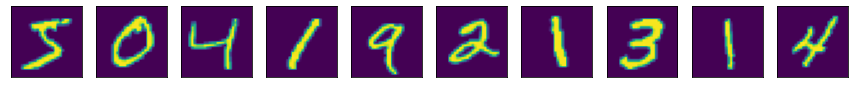

In [10]:
indices = range(0, 10)
images, labels = get_data(mnist_train, indices, False)
print([images.shape, labels.shape])
print(images[0, 15:20, 15:20])  # not binary
_ = show_images(images, 1, 10)

[(10, 28, 28), (10,)]
[[ True  True  True  True False]
 [False False  True  True  True]
 [False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


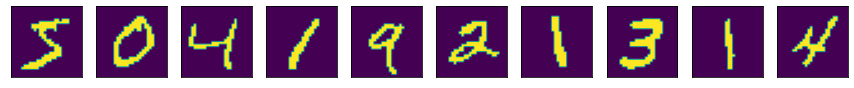

In [11]:
indices = range(0, 10)
images, labels = get_data(mnist_train, indices, True)
print([images.shape, labels.shape])
print(images[0, 15:20, 15:20])  # binary
_ = show_images(images, 1, 10)

In [12]:
X_train, y_train = get_data(mnist_train)
X_test, y_test = get_data(mnist_test)

In [13]:
print(X_train.shape)
print(type(X_train))

print(X_train[0, 15:20, 15:20])

(60000, 28, 28)
<class 'jaxlib.xla_extension.DeviceArray'>
[[ True  True  True  True False]
 [False False  True  True  True]
 [False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


# Training


In [14]:
n_y = jnp.zeros(10)
for y in range(10):
    n_y = n_y.at[y].set((y_train == y).sum())
P_y = n_y / n_y.sum()
P_y

DeviceArray([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
             0.09035   , 0.09863333, 0.10441667, 0.09751666, 0.09915   ],            dtype=float32)

In [15]:
# Training set is not equally balanced across classes...
print(jnp.unique(y_train))
from collections import Counter

cnt = Counter(np.asarray(y_train))
print(cnt.keys())
print(cnt.values())

[0 1 2 3 4 5 6 7 8 9]
dict_keys([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])
dict_values([5421, 5923, 5842, 6742, 5949, 5958, 6131, 5918, 6265, 5851])


We use add-one smoothing for class conditional Bernoulli distributions.


In [16]:
n_x = jnp.zeros((10, 28, 28))
for y in range(10):
    n_x = n_x.at[y].set(X_train[y_train == y].sum(axis=0))
# using pseudo counts of 1
# P_xy = (n_x + 1) / (n_y + 1).reshape(10, 1, 1)
P_xy = (n_x + 1) / (n_y + 2).reshape(10, 1, 1)
print(P_xy.shape)
print(type(P_xy))

(10, 28, 28)
<class 'jaxlib.xla_extension.DeviceArray'>


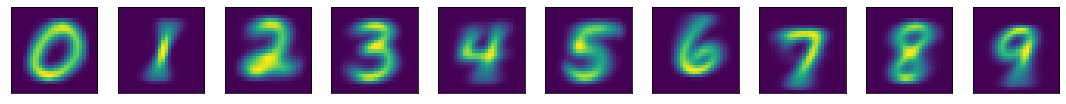

In [17]:
show_images(P_xy, 1, 10)
plt.tight_layout()
plt.savefig("nbc_mnist_centroids.pdf", dpi=300)

# Testing


In [18]:
log_P_xy = jnp.log(P_xy)
log_P_xy_neg = jnp.log(1 - P_xy)
log_P_y = jnp.log(P_y)


def bayes_pred_stable(x):
    # x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    x = jnp.expand_dims(x, 0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)  # select the 0 and 1 pixels
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # p(x|y)
    return p_xy + log_P_y


def predict(X):
    return jnp.array([jnp.argmax(bayes_pred_stable(x)) for x in X])


# image, label = mnist_test[0]
image = X_test[0]
label = y_test[0]
py = bayes_pred_stable(image)
print(py)
print("ytrue ", label, "yhat ", np.argmax(py))
print(predict([image]))

[-268.9725   -301.7044   -245.19514  -218.87386  -193.45703  -206.09087
 -292.52264  -114.625656 -220.33133  -163.17844 ]
ytrue  7 yhat  7
[7]


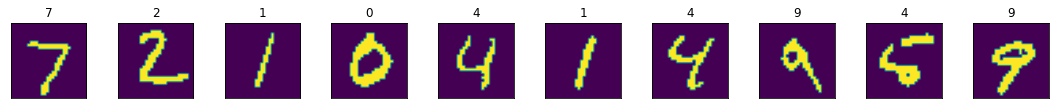

In [19]:
indices = range(0, 10)
X1, y1 = get_data(mnist_test, indices, True)
preds = predict(X1)
show_images(X1, 1, 10, titles=[str(d) for d in preds])
plt.tight_layout()
plt.savefig("nbc_mnist_preds.pdf", dpi=300)

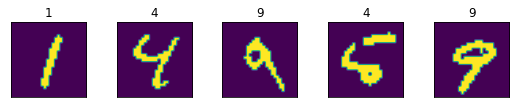

In [20]:
indices = range(5, 10)
X1, y1 = get_data(mnist_test, indices, True)
preds = predict(X1)
show_images(X1, 1, 5, titles=[str(d) for d in preds])
plt.tight_layout()
plt.savefig("nbc_mnist_preds.pdf", dpi=300)

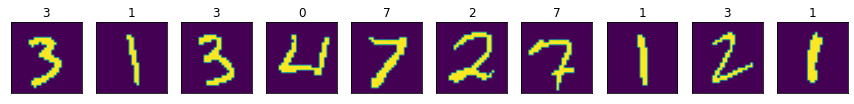

In [21]:
indices = range(30, 40)
X1, y1 = get_data(mnist_test, indices, True)
preds = predict(X1)
_ = show_images(X1, 1, 10, titles=[str(d) for d in preds])

In [22]:
preds = predict(X_test)
float(jnp.count_nonzero(preds == y_test)) / len(y_test)  # test accuracy

0.8427